The code is taken from [https://github.com/diegoalejogm/gans/](https://github.com/diegoalejogm/gans/blob/master/2.%20DC-GAN%20PyTorch.ipynb)

<a href="https://colab.research.google.com/github/HSE-LAMBDA/GenModels-2020/blob/main/day2/dcgan_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from comet_ml import Experiment
from IPython import display

import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

from torchvision import transforms, datasets
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Create an experiment with your api key:
experiment = Experiment(
    api_key="lODeHEtCf7XLaV6DJrOfugNcA",
    project_name="gm-archipelago2035",
    workspace="holybayes",
)


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/holybayes/gm-archipelago2035/3fa81a9a0de74ba8bc9fd7cf73a8b1e9



In [3]:
DATA_FOLDER = './data/'

## Load Data

In [4]:
def cifar_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=False)

In [5]:
data = cifar_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 7


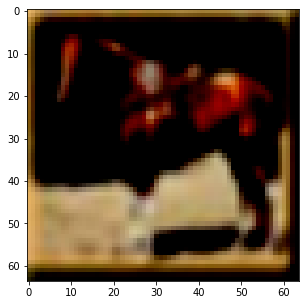

In [8]:
def plot_image(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.detach().cpu().permute(1, 2, 0))
    plt.show()

img, label = next(iter(data_loader))
print(f'Label: {label[0]}')
plot_image(img[0])

## Networks

Наша цель - построить простейший GAN, составленный из двух частей, генератора и дискриминатора.

1. Генератор G принимает на вход шум из какого-то заранее заданного латентного пространства и преобразует его в какую-то картинку заданной размерности (в нашем случае 3x32x32). 
2. Дискриминатор D принимает на вход какую-то картинку заданной размерности и выдает вероятность того что картина - реальная (не сгенерированная)

![im](https://lilianweng.github.io/lil-log/assets/images/GAN.png)

Для обучения такой конструкции мы можем использовать простую бинарную кросс-энтропию:

$$\text{BCE}(\hat{y}, y) = \frac{1}{N} \Sigma^N_{i=0} y_i * \log \hat{y}_i + (1 - y_i) * \log (1 - \hat{y}_i)$$

### D:

С одной стороны, мы хотим получать предсказания близкие к единице на реальных данных -> максимизировать $E_{x \sim P_{real}} \log D(x)$

С другой стороны, мы хотим получать предсказания близкие к нулю для сгенерированных данных -> минимизировать $E_{x \sim P_{gen}} \log (1 - D(x))$

### G:

Генератор в свою очередь должен уметь "обманывать" дискриминатор - получать единицы от D на сгенерированных данных -> минимизировать $E_{x \sim P_{gen}} \log (1 - D(x))$

Тогда мы приходим к такой задаче:

$$
\min_G \max_D L(D, G) = \mathbb{E}_{x \sim p_{\text{real}}(x)} [\log D(x)] + \mathbb{E}_{x \sim p_\text{gen}(x)} [\log(1 - D(x)]
$$

In [9]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

In [10]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=3, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda()
    return n

In [11]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [12]:
# Create Network instances and init weights
generator = GenerativeNet()
generator.apply(init_weights)

discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

## Optimization

In [13]:
# Optimizers
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 200

## Training

In [14]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [15]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Generate Samples for Testing

In [16]:
num_test_samples = 16
test_noise = noise(num_test_samples)

### Start training

In [ ]:
from torchvision.utils import make_grid

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        experiment.log_metrics({'Generator loss': g_error.item(),
                        'Discriminator loss': d_error.item()},
                        epoch = epoch,
                        step = n_batch)        
        # Display Progress
        if (n_batch) % 100 == 0:
            plt.figure(figsize = (10,10))

            plt.title(
                f"[Epoch {epoch}/{num_epochs}]" + \
                f"[Batch {n_batch%len(data_loader)}/{len(data_loader)}]" + \
                f"[D loss: {d_error.item()}] [G loss: {g_error.item()}]"
            )

            plt.imshow(make_grid(fake_data.data[:25]).cpu().detach().numpy()[0, :, :])
            experiment.log_figure()
            plt.clf()

<ipython-input-17-ba63a5858935>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,10))


In [20]:
torch.save(generator.state_dict(), 'gen.ckpt')
torch.save(discriminator.state_dict(), 'disc.ckpt')